# The First Step in Bayesian Time Series— Linear Regression

# Introduction

Today time series forecasting is ubiquitous, and decision-making processes in companies depend heavily on their ability to predict the future. Through a short series of articles I will present you with a possible approach to this kind of problems, combining state-space models with Bayesian statistics.

In the initial articles, I will take some of the examples from the book An Introduction to State Space Time Series Analysis from Jacques J.F. Commandeur and Siem Jan Koopman [1]. It comprises a well-known introduction to the subject of state-space modeling applied to the time series domain.

My contributions will be:

* A very humble attempt to close the gap between these two fields in terms of introductory and intermediate materials.
* The presentation of concepts: on the one hand, a concise (not non-existent) mathematical basis to support our theoretical understanding and, on the other hand, an implementation from scratch of the algorithms (whenever possible, avoiding “black box” libraries). In my opinion, it is the best way to make sure that we can grasp an idea.
* The proper implementation of the proposed models using PyMC3 as well as their interpretation and discussion

# 1. Linear regression

In classical regression analysis, it is assumed a linear relationship between a dependent variable $y$ and a predictor variable $x$. The standard regression model for $n$ observations of $y$ (denoted by $y_i$ for $i= 1, …,n$) and $x$ (denoted by $x_i$ for $i= 1,…,n$) can be written as,

$$ y_i = \alpha + \beta x_i + \epsilon_i, \quad ϵ_i \sim NID(0, σ_\epsilon^2) $$

where the $ϵ_i \sim NID(0, σ_ϵ^2)$ states the assumption that the residuals (or errors) $\epsilon$ are normally and independently distributed with mean equal to zero and variance equal to $\sigma^2_\epsilon$.

## 1.1 The data

This dataset comprises the monthly number of drivers killed or seriously injured (KSI) in the UK for the period January 1969 to December 1984, and you can find it here.

We will be using the log number of deaths. The log transformation can be used to turn highly skewed distributions into less skewed ones. This can be valuable both to make patterns in the data more easily interpretable and to help meeting the assumptions of inferential statistics. We will see what this means later on.

In [12]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
import arviz as az
import warnings
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

ukdrivers = np.genfromtxt('./data/UKdriversKSI.txt', skip_header=True)
y = np.log(ukdrivers)
t = np.arange(1,len(y)+1)

In our case our independent variable is just time.

## 1.2 Classical approach

The regression model has two unknown parameters that can be estimated with the least-squares method. It returns the values of $\alpha$ and $\beta$ that yield the lowest average quadratic error between the observed $y$ and the predicted $\hat y$.

$$\min_{\alpha, \beta} S(\alpha, \beta), \quad \textrm{for} \: S(\alpha, \beta) = \sum^n_{i=1}\hat \epsilon^2 = \sum^n_{i=1}(y_i - \alpha - \beta x_i)^2 $$

The goal is to find the values of $\hat \alpha$ and $\hat \beta$ that minimize the error. For that, we just to take the partial derivatives for each parameter and make it equal to zero as follows,

$$\begin{aligned}
\frac{\partial S}{\partial \alpha} = 0, \quad \frac{\partial S}{\partial \beta} = 0 
\end{aligned}$$

After computing the equations above, we get the following,

$$\begin{aligned}
\hat \beta &= \frac{\sum^n_{i=1}(x_i - \bar x)(y_i - \bar y)}{\sum^n_{i=1}(x_i - \bar x)^2} \\
\hat \alpha &= \bar y - \hat \beta \bar x
\end{aligned}$$

In [13]:
print('Least Squares\n')
β_hat = np.sum((t - t.mean())*((y - y.mean()))) / np.sum((t - t.mean())**2)
α_hat = y.mean() - β_hat*t.mean()
print("\u0302α: " + str(α_hat))
print("\u0302β: " + str(β_hat))

Least Squares

̂α: 7.545842731731763
̂β: -0.0014480324206279402


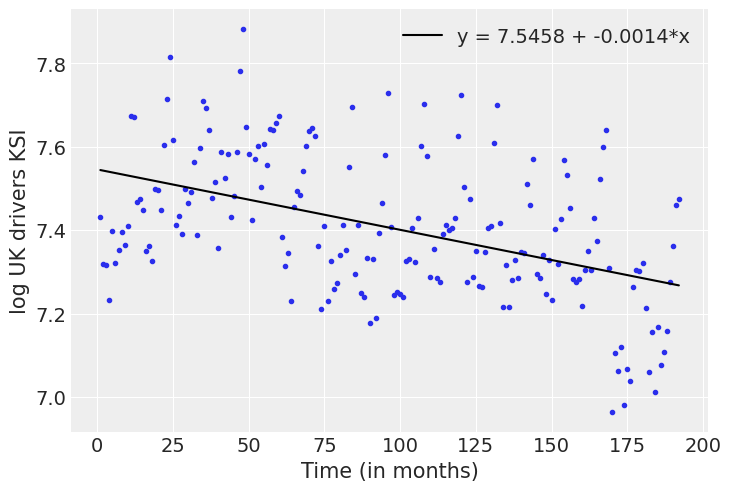

In [14]:
plt.plot(t, y, 'C0.')

plt.plot(t, α_hat + β_hat *t, c='k',
        label=f'y = {α_hat:.4f} + {β_hat:.4f}*x')

plt.ylabel('log UK drivers KSI')
plt.xlabel('Time (in months)', rotation=0)

plt.legend();

The error variance using least squares estimate can be calculated using

$$\hat\sigma^2_\epsilon = \sum^n_{i=1} (y_i - \hat \alpha - \hat \beta x_i)^2 / (n-2)$$

In [15]:
np.sum((y - α_hat - β_hat * t)**2/(len(y)-2))

0.022998056021100423

## 2. The Bayesian way

Bayes theorem without context could work as a mousetrap. Despite the relatively simple and widely known equation, there is a lot of intuition behind it. I once read that it could be seen as a lens to perceive the world. I would say that it shows a different perspective. There are useful resources to get that intuition; therefore, I will not focus too much on it. Our scope of work is on its practical aspects, making it work for our advantage. First, let’s briefly define its components.

$$ \textrm{posterior} = \frac{\textrm{likelihood}\times \textrm{prior}}{\textrm{normalization}}$$

We are starting with the basics: the *prior* is the probability of something happening before we include the probability of the data (the *likelihood*), and the *posterior* is the probability after incorporating the data.

Bayes theorem [[*2*]](https://en.wikipedia.org/wiki/Bayes%27_theorem) is written as

$$P(A\mid B) = \frac{P(B\mid A)\, P(A)}{P(B)}$$

In the equation above, $P(B)$ is the evidence, $P(A)$ is the prior, $P(B | A)$ is the likelihood, and $P(A | B)$ is the posterior. $P(A | B)$ is the probability of $A$ happening if $B$ has happened. We can plug into the equation both probabilities and probability distributions (more important to our present work).

### 2.1 Model definition

Now, it is time to define our simple linear regression as a probabilistic model. We will assume that the data follow a Gaussian distribution with a mean of $\alpha + \beta x$ and a standard deviation of $\epsilon$, as follows

$$\mathrm{Y} \sim \mathcal{N}(\mu = \alpha + x \beta, \epsilon)$$

We are essentially choosing our likelihood, i.e., we assigned a distribution function to our observed variable (data). As a next step, we need to define our priors. For every parameter (our unobserved variables), we need to define a prior distribution. Think of it as a prior belief or, in the case that you have previous estimates of the parameter, those previous estimates become the prior. Since we don’t know much about the parameters, let’s define some generic distributions

$$\begin{aligned}
\alpha &\sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta &\sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon &\sim |\mathcal{N}(0, \sigma_\epsilon)| 
\end{aligned}
$$

As it is our first model, we are going to be vague about our choices. In Bayesian terms, this means that we will be using flat priors. Working with the basics of our understanding of the model, we know that ϵ can’t be a negative number, and our slope is relatively small. We will be refining our way of choosing priors later. When applying these ideas, we will only use Gaussian and Half-Gaussian distributions

$$\begin{aligned}
\alpha &\sim \mathcal{N}(0, 10) \\
\beta &\sim \mathcal{N}(0, 1) \\
\epsilon &\sim |\mathcal{N}(0, 5)| 
\end{aligned}
$$


Let’s plot these distributions for a better understanding of what we mean by a flat distribution.

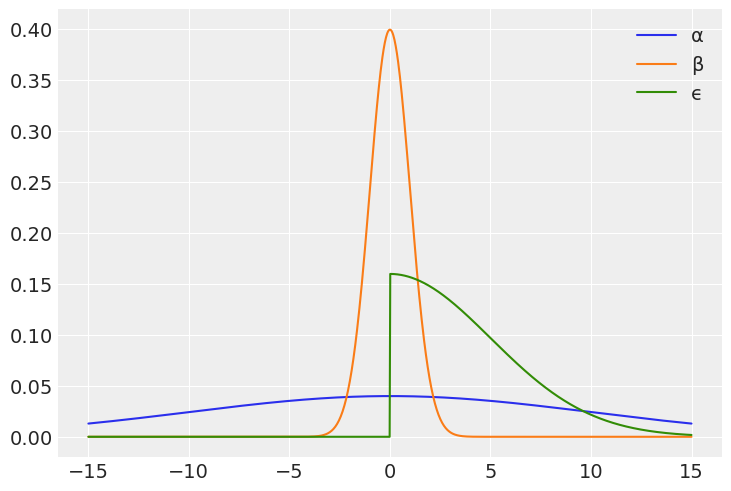

In [16]:
_, ax = plt.subplots(1,1)

x = np.linspace(-15,15,1000)
ax.plot(x,stats.norm.pdf(x,0,10), label='α')
ax.plot(x,stats.norm.pdf(x,0,1), label='β');
ax.plot(x,stats.halfnorm.pdf(x,0,5), label='ϵ')
ax.legend();

We can see above that we are not informing our Bayesian model about what the values of our parameters could be. It means that the data will have a substantial impact on our posterior distributions. We will learn in the future how to reflect our prior choices in our observable variable without seeing the data. We call this model step the *prior predictive check*, and it helps in diagnosing poor modeling choices.

### 2.2 Model checking

We always like to start by generating our own data and ensuring that the model is well specified. It brings significant value to more complex models, but we will be using this approach as a good practice in all examples.  

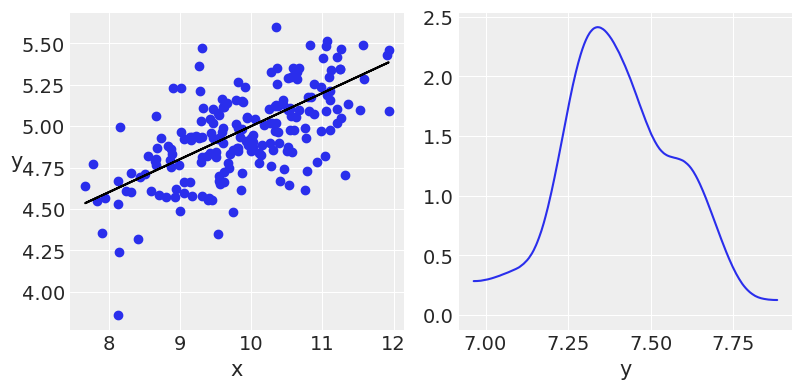

In [17]:
n = 200
true_α = 3
true_β = 0.2
true_ϵ = 0.2
ϵ = np.random.normal(0, 0.2, n)

x = np.random.normal(10, 1, n)
true_Y = true_α + true_β * x
Y = true_Y + ϵ

_, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(x, Y, 'o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, true_Y, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

We can see above the data that we generated and the fitted line that we are expecting to recover from it, i.e., we want to get our true parameters back from the data.

PyMC3 lets us translate the model that we defined above in a very clean matter. First, we define the prior distributions of our parameters, followed by the likelihood. And we are ready to sample!

In [23]:
with pm.Model() as model_l:
    
    # priors
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu=α + β*x, sd=ϵ, observed=Y)
    trace_l = pm.sample(
        2000,
        tune=3000
    )
    idata = az.from_pymc3(trace_l)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 18 seconds.


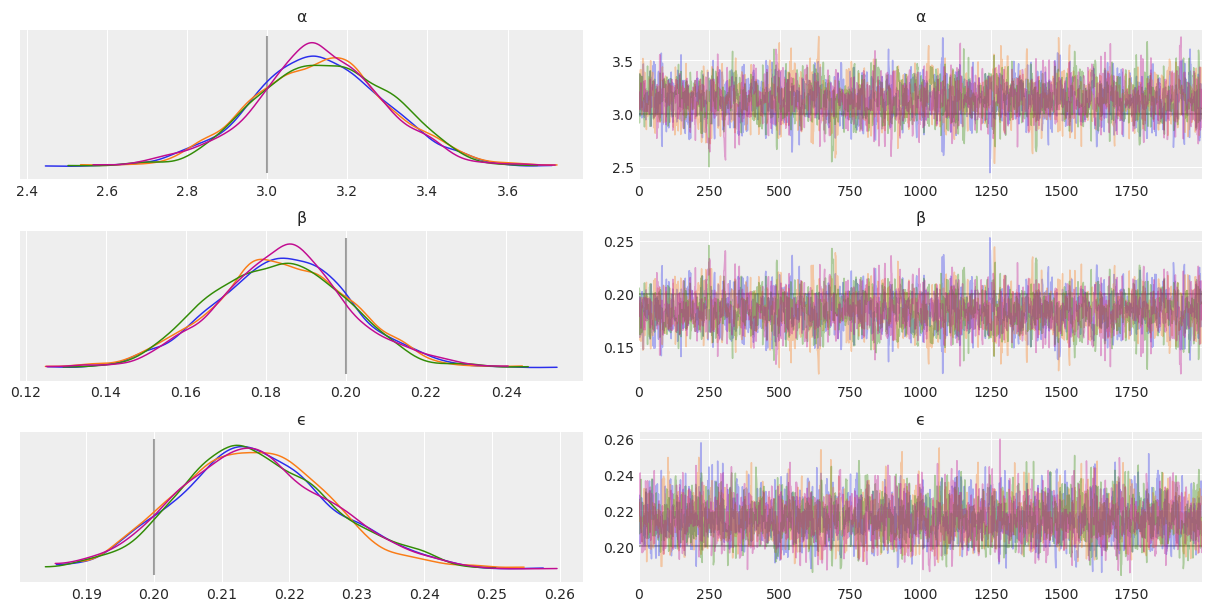

In [24]:
az.plot_trace(
    idata,
    var_names=['α', 'β', 'ϵ'],
    lines=[
        ("α",{}, true_α),
        ("β",{}, true_β),
        ("ϵ",{}, true_ϵ),
    ],
);

We will understand these plots in much greater detail later, but I just wanted to show you that we are recovering our true values well. For now, focus on the distributions of the parameters (plots on the left). These are our posterior distributions of the parameters that we are estimating, and the vertical lines represent the true values. We can see that we are pretty close to those true values. Remember that we used flat priors, and we generated a relatively small dataset (200 points).

### 2.3 Model implementation

Now, it is time to apply our verified model to our data.

In [25]:
with pm.Model() as model_l:
    
    # priors
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    
    # likelihood
    y_pred = pm.Normal('y_pred', mu=α + β*t, sd=ϵ, observed=y)
    trace_l = pm.sample(
        2000,
        tune=3000
    )
    idata = az.from_pymc3(trace_l)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.7090830743724367, but should be close to 0.8. Try to increase the number of tuning steps.


### 2.4 Model visualization

Another way to visualize our model and to ensure that we have correctly done the translation from the mathematical enunciation is to use Kruschke diagrams.

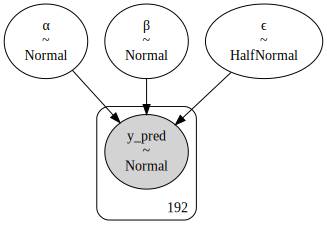

In [26]:
pm.model_to_graphviz(model_l)

It is easier for us to grasp our understanding of the model with the diagram above. Inside every node, we find both the variables and the distributions, e.g., check the circle that contains $\epsilon$ and you can find the Half-Normal distribution defined earlier. The observed variable is represented by the shaded node. The rounded-corner box indicates repetition, i.e., we have 192 data points in our dataset, and we will be computing the likelihood for all of them. The arrows show the dependencies; in our case, our likelihood depends on the parameters $\alpha$, $\beta$, and $\epsilon$.

Now that we are confident that we have setup correctly our model, it is time to analyze our results. For that, let’s plot the results in a similar fashion as we did earlier with the classical approach.

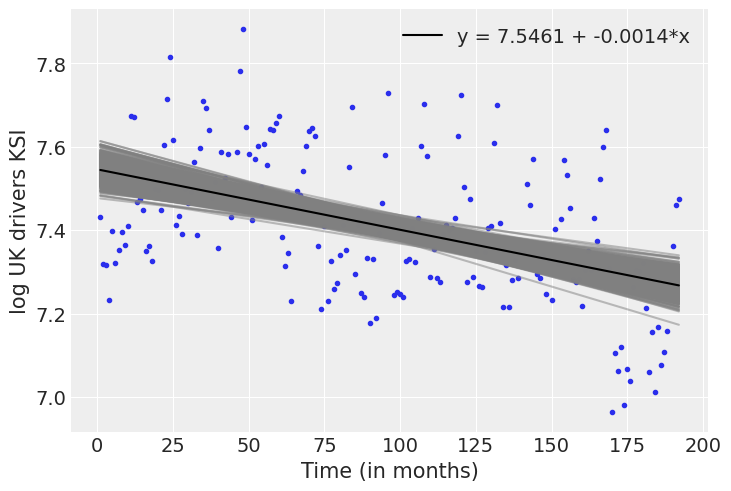

In [27]:
plt.plot(t, y, 'C0.')

alpha_m = trace_l['α'].mean()
beta_m = trace_l['β'].mean()

draws = range(0, len(trace_l['α']), 10)
plt.plot(t, trace_l['α'][draws] + trace_l['β'][draws] * t[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(t, alpha_m + beta_m *t, c='k',
        label=f'y = {alpha_m:.4f} + {beta_m:.4f}*x')

plt.ylabel('log UK drivers KSI')
plt.xlabel('Time (in months)', rotation=0)

plt.legend();

The first thing to notice is that the black line is very similar to the one that we got from the classical linear regression. As we already mentioned, we don’t get just point estimates but a distribution — our posterior distribution. The gray lines are there to represent our uncertainty about the estimation. I added them to make it more interesting and to give you a first glimpse of what we will be analyzing in the next articles.

### 2.5 Bayesian vs classical approach

For now, let’s compare the point estimates for both models.

In [28]:
print("Bayesian model\n")
alpha_m = trace_l['α'].mean()
print("\u0302α: " + str(alpha_m))
beta_m = trace_l['β'].mean()
print("\u0302β: " + str(beta_m))
print('\n---\n')
print('Least Squares\n')
b_hat = np.sum((t - t.mean())*y) / np.sum((t - t.mean())**2)
a_hat = y.mean() - b_hat*t.mean()
print("\u0302α: " + str(a_hat))
print("\u0302β: " + str(b_hat))

Bayesian model

̂α: 7.546050895768653
̂β: -0.0014494569493230078

---

Least Squares

̂α: 7.545842731731764
̂β: -0.0014480324206279495


Let’s also check the standard deviation of our residuals.

In [29]:
σ_error = trace_l['ϵ'].mean()
σ_error**2

0.023251359382951184

We are really close! The reason why they yield similar results is that the point estimate obtained by the least-squares method is, in reality, the same thing as the *maximum a posteriori* (MAP) (the mode of the posterior) from a Bayesian linear regression using flat priors (as we did here). Later on we will deep dive into all of this.

## 3. Discussion

One problem with our approach here is that we are violating a fundamental assumption of classical regression analysis. It is assumed that the observations y are independent of each other. It is not the case with our example because they are interrelated through time. To show that this is the case, let’s consider:

* Plot the same graph for t and y, this time with a line connecting all the points;
* Plot the residuals.

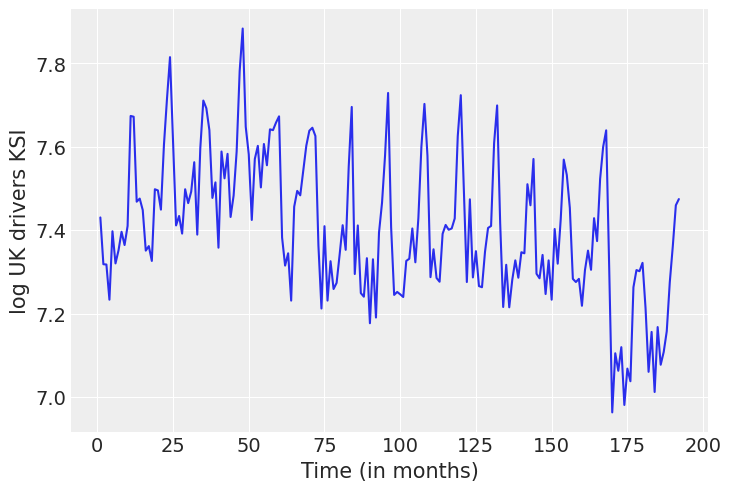

In [30]:
plt.plot(t, y)
plt.ylabel('log UK drivers KSI')
plt.xlabel('Time (in months)', rotation=0);

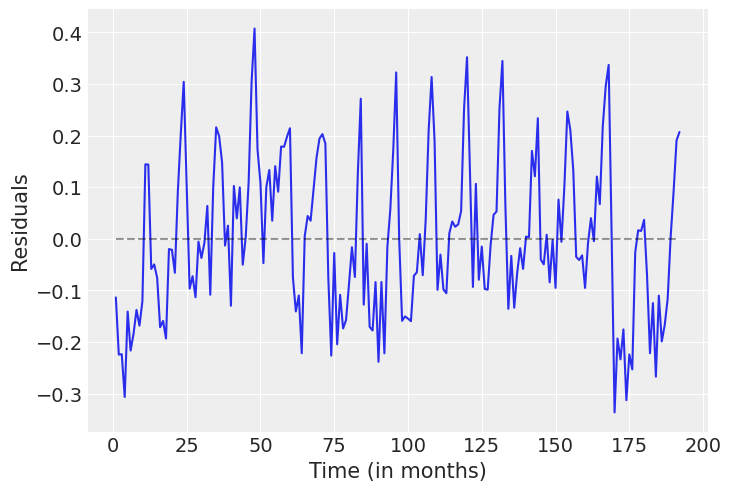

In [31]:
residuals = y - (a_hat + b_hat*t)
plt.plot(t, residuals)
plt.plot(t, np.zeros(len(y)), '--', c='k', alpha=0.4)
plt.ylabel('Residuals')
plt.xlabel('Time (in months)', rotation=0);

On the one hand, we can see a clear pattern on our data and also that our residuals are far from being randomly distributed.

Let’s look at other handy tools to diagnose the randomness of a set of observations. I’m talking about the correlogram, which contains the correlation between an observed series, and the same series shifted k time points into the future. For the least-squares case, remember that it is computed by

$$\hat \epsilon_i = y_i - \hat \alpha - \hat \beta x_i$$

Let's look to other tool very useful to diagnose the randomness of a set of observations. I'm talking about the *correlogram*, which contains the correlation between an observed series and the same series shifted $k$ time points into the future. Remember that for the least squares case it is computed by $\hat \epsilon_i = y_i - \hat \alpha - \hat \beta x_i$. Notice that we are using $t$ to simplify our understanding that the independent variable is nothing more than time.

Notice that we are using $t$ to simplify our understanding that the independent variable is nothing more than time.

By plotting the residuals against the residuals with a lag (time difference), we are plotting the same variable against itself — therefore, the name autocorrelations. We need to grasp this idea well, so it makes sense to lose a bit more time with this subject.

### 3.1. Correlation

First, we are going to introduce the concept of *covariance*. It describes how much two variables vary together. We could say that variance is a measure for how a population varies amongst themselves, and covariance is a measure for how much two variables change with each other.

The equation for the covariance between X and Y is

$$ \mathrm{cov}(X, Y) = \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]$$

I'm using X and Y to simplify the subscripts but you know that for us $X$ is $Y_t$ and $Y$ is $Y_{t-1}$. The notation $\mathbb E[Y]$ is nothing more than the *expected value* of Y. Assuming that each data point is equally likely, the probability of each is $\frac{1}{n}$, giving

$$\mathbb E[Y] =  \frac{1}{n}\sum_{i=1}^n y_i$$

for the discrete case, we will be considering. Certainly, you already spotted that this is simply the mean value of our time series (also denoted by $\bar y$).

Now that we understand the covariance, we can extend this idea to *correlation* (also known as Pearson correlation coefficient), which is simply the covariance normalized by the square root of the variances of our random variables. 

$$ \rho_{X, Y} = \mathrm{corr}(X, Y) = \sigma_{xy} = \frac{ \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]}{\sigma_X \sigma_Y}$$

### 3.2 Autocorrelation

For our problem (at least at this moment), we are not particularly interested in the correlation of two random variables but instead in one random variable with itself. Let’s create our series to be able to visualize it better. We have to ensure that it is not independent across time (creating the correlations that we want to check).

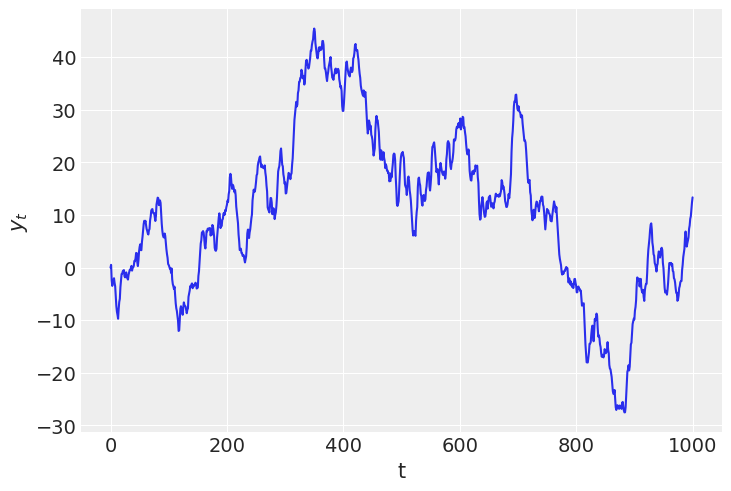

In [37]:
y = [0]

for i in range(1000):
    y.append(np.random.randn() + y[-1]*0.5)
    
y = np.asarray(y)
plt.plot(np.cumsum(y))

plt.ylabel('$y_t$')
plt.xlabel('t', rotation=0);

We can see that we made our $Y$ explicitly dependent on its own previous value. We used a coefficient to define how much the current value is correlated with the previous one - feel free to test with other values. We will understand much better the usefulness of these coefficients later. Let's plot $Y_t$ against $Y_{t-1}$ and see what we get. 

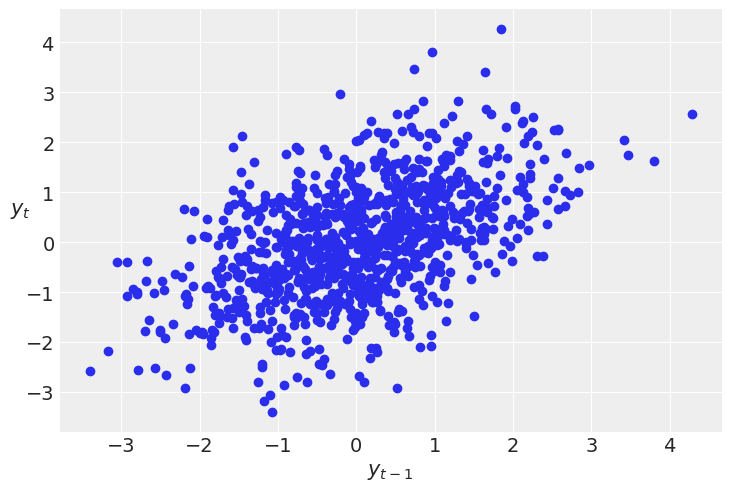

In [38]:
plt.plot(y[:-1], y[1:], 'o');
plt.xlabel('$y_{t-1}$')
plt.ylabel('$y_t$', rotation=0);

From the plot above, we can immediately see that both variables are positively correlated. What does this really tells us about our model? Let's find out.

### 3.3 Autocorrelation function

Now we are going to generalize the autocorrelation function or ACF (see more here [[3]](https://www.real-statistics.com/time-series-analysis/stochastic-processes/autocorrelation-function/)). The ACF at lag $k$ of a stationary stochastic process is defined as $\mathrm{cov}(Y_i, Y_{i+k})$ for any $i$ divided by the variance of the stochastic process.

Using the equation above we can say that the autocorrelation function at lag k, for k $\geq$ 0, is defined by

$$\mathrm{ACF}(Y_t, Y_{t-k}) = \frac{ \mathbb E\big[(Y_t-\mu_t)(Y_{t-k}-\mu_{t-k})\big]}{\sigma_t \sigma_{t-k}}$$

Let's build our own ACF.

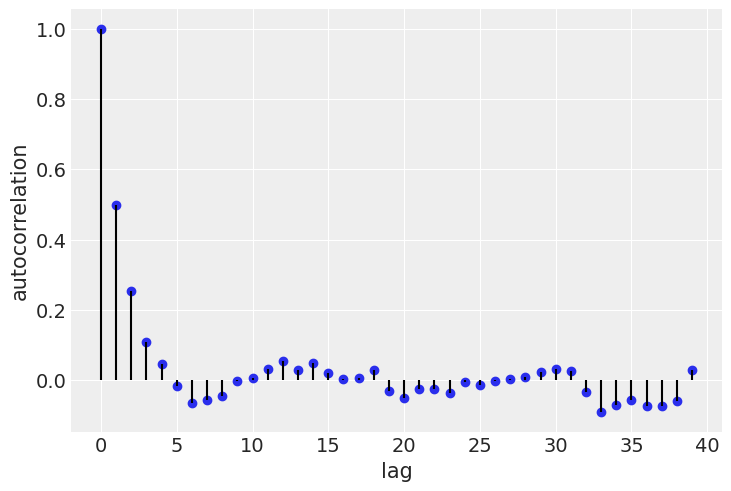

In [39]:
def correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

def acf_calc(y, lag=40):
    return np.array([1] + [correlation(y[:-i], y[i:]) for i in range(1, lag)])

def acf_plot(y, alpha=0.05, lag=40):
    acf_val = acf_calc(y, lag)
    plt.vlines(np.arange(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')

acf_plot(y);

We can see the autocorrelations and they seem high for some lags, but how high? We need a lower and an upper bound to be able to answer that question. If we assume that the time-series is Gaussian and if the autocorrelation is higher or lower than these upper or lower bounds, respectively, the null hypothesis is rejected. It states that there is no autocorrelation at and beyond a given lag at a significance level of α (here we are doing hypothesis tests and throwing accepted but somewhat random values of significance — not so Bayesian). Our upper and lower bounds can be computed using

$$B = \pm z_{1-\alpha/2}SE(r_k)$$

where we will use $\alpha = 5$%, SE is the standard error and $r_k$ is the estimated autocorrelation at lag k. SE can be calculated using Barlett's formula

$$SE(r_k) = \sqrt{\frac{1+2\sum^{h-1}_{i=1}r_i^2}{n}} \quad\mathrm{\;for} \;h > 1$$

In [40]:
def standard_error(acf_values, n):
    se = np.zeros(len(acf_values) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_values[1:-1]**2)) / n )
    return se

def acf_plot(y, alpha=0.05, lag=40):
    acf_values = acf_calc(y, lag)
    plt.vlines(np.arange(lag), 0, acf_values)
    plt.scatter(np.arange(lag), acf_values, marker='o')
    ci = stats.norm.ppf(1 - alpha / 2.) * standard_error(acf_values, len(y))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, color='blue', alpha=0.2)
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')

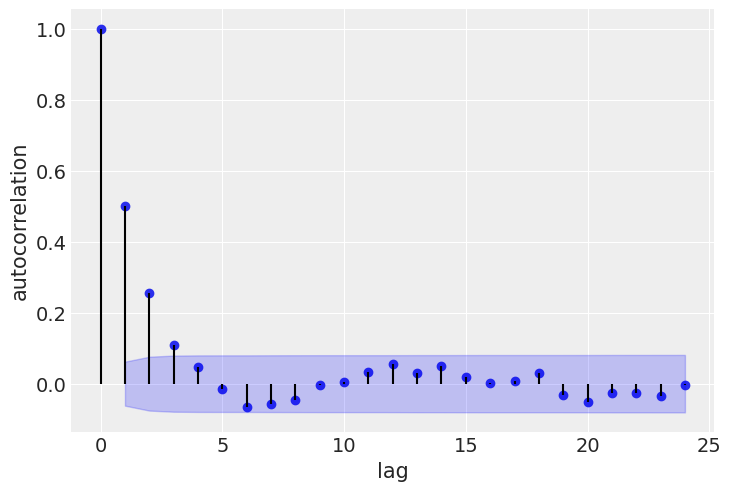

In [41]:
acf_plot(y, lag=25);

Now that we know how to calculate our ACF and upper and lower bounds, we can use a library to do it for us.

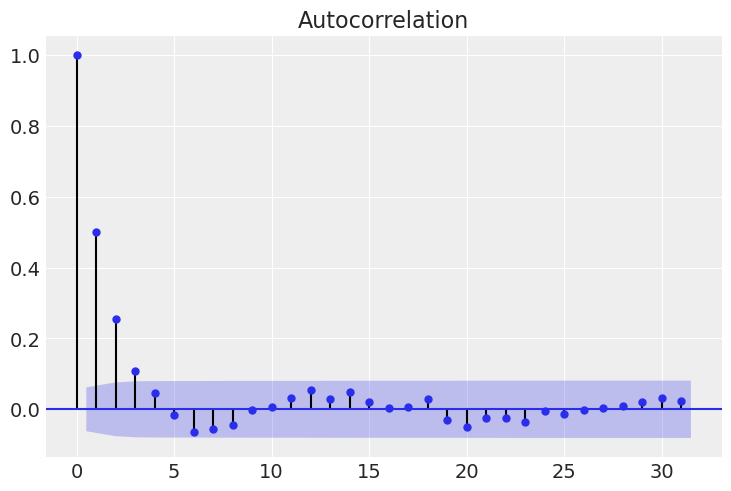

In [42]:
from statsmodels.graphics.tsaplots import acf, plot_acf
acf_stats = acf(y)
plot_acf(y);

### 3.4 Residuals Correlogram

We are finally ready to do the *correlogram* for the residuals of our UK drivers data and, most importantly, to analyze it.

The main idea is that if residuals are randomly distributed (what we want them to be), then they are independent of one another. It is shown in the correlogram in all the bars that do not exceed our confidence limits. We are going to use what we have learned so far.

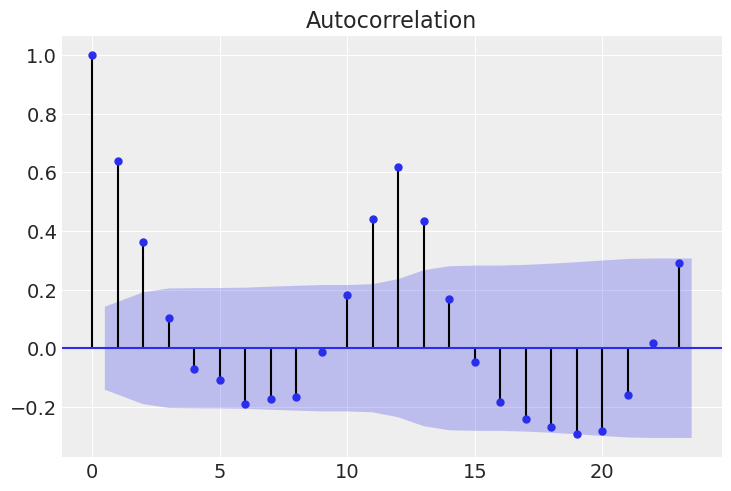

In [43]:
plot_acf(residuals);

It doesn't look that nice; there are quite a few number of bars that exceed the blue shadowed area. We can see that $k=1$, $k=2$, $k=11$, $k=12$ and $k=13$ are outside of those limits ($k=0$ is always 1 as we showed above when calculating the ACF manually, because it is the correlation of each point with itself). We say that these are significantly different from zero, and this shows that we violated the assumption that errors are randomly distributed when we used a classical linear regression. 

# 4. Conclusions

We have set up two different models that fundamentally do the same thing: they use time as an explanatory variable, and they linearly model its relationship with the log number of UK drivers KSI. The first approach was a classical linear regression model fitted using the standard least-squares method. The second one was our first Bayesian model, expanding on the idea of point estimates to posterior (and prior) distributions. Nevertheless, the results are not satisfactory. Our residuals are far from randomly distributed, which is a consequence of our observations not being independent of each other. We need new tools to solve this problem. Essentially, there is an underlying dynamic evolution that cannot be observed and we are unable to model it. This is where state-space models come in. The state describes precisely the unobserved dynamic process over time. In the next article, we will be setting up our first state-space model!

# References

[1] J. Commandeur, S. Koopman, An Introduction to State Space Time Series Analysis (2007), Oxford University Press

[2] https://en.wikipedia.org/wiki/Bayes%27_theorem

[3] https://www.real-statistics.com/time-series-analysis/stochastic-processes/autocorrelation-function/